<a href="https://colab.research.google.com/github/AlKazakova/pet_project/blob/main/test_coefficient_prolongations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Tuple

MONTHS = {'Ноябрь 2022': '2022_11',
          'Декабрь 2022': '2022_12',
          'Январь 2023': '2023_01',
          'Февраль 2023': '2023_02',
          'Март 2023': '2023_03',
          'Апрель 2023': '2023_04',
          'Май 2023': '2023_05',
          'Июнь 2023': '2023_06',
          'Июль 2023': '2023_07',
          'Август 2023': '2023_08',
          'Сентябрь 2023': '2023_09',
          'Октябрь 2023': '2023_10',
          'Ноябрь 2023': '2023_11',
          'Декабрь 2023': '2023_12',
          'Январь 2024': '2024_01',
          'Февраль 2024': '2024_02'}

REPLACEMENT_VALUES = [{r'\xa0': ' '}, {',': '.'}, {' ': ''}, {'вноль': '0'}, {'стоп': '0'}, {'end': '0'}]
PATTERN = (r'2022_\d{2}', '2024_\d{2}')
ROOT = Path('/content/')
dataset_prolong = pd.read_csv(ROOT / 'prolongations.csv')
dataset_fin = pd.read_csv(ROOT / 'financial_data.csv')

In [86]:
# Функция, удаляющая столбцы за 2022 и 2024 года
def delete_columns(df_res: pd.DataFrame, YEARS: Tuple[str]):
  for year in YEARS:
    if isinstance(df_res, pd.DataFrame):
      df_res = df_res.loc[:, ~df_res.columns.str.contains(year, case=False)]
    else:
      df_res = df_res.drop(columns=[year])
      df_res = df_res.loc[~df_res.index.str.contains(year, case=False)]
  return df_res

In [38]:
# Почистим данные
def clean_value(dataset_prolong: pd.DataFrame, dataset_fin: pd.DataFrame) -> pd.DataFrame:
  #переименуем значения для удобства
  dataset_prolong['month'] = dataset_prolong['month'].str.capitalize().replace(MONTHS)
  #отфильтруем 2022 год и сложим суммы отгрузок для каждого менеджера
  df_prolong = dataset_prolong[~dataset_prolong['month'].str.contains('2022')]
  df_prolong = df_prolong.groupby(['AM', 'month'], as_index=False).agg('count')
  # переименуем столбцы для удобства
  df_fin = dataset_fin.rename(columns=MONTHS)
  # преобразуем суммы отгрузок из типа object в float
  columns_financial = df_fin.iloc[:, 2:18].columns
  for dictionary in REPLACEMENT_VALUES:
    df_fin[columns_financial] = df_fin[columns_financial].replace(dictionary, regex=True)
  df_fin[columns_financial] = df_fin[columns_financial].astype('float')
  return df_prolong, df_fin

In [80]:
# Рассчитаем коэффициент пролонгации за каждый месяц
def get_coeff_per_month(df_fin: pd.DataFrame, df_prolong: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
  dff_fin = df_fin.drop(columns=['Причина дубля', 'id'])
  dff_fin = dff_fin.groupby('Account').sum()
  df_res1, df_res2 = (pd.DataFrame(columns=dff_fin.columns, index=dff_fin.index),
                      pd.DataFrame(columns=dff_fin.columns, index=dff_fin.index))
  for name in dff_fin.index:
    df_prolog_name = df_prolong.query("AM == @name")
    df_fin_name = dff_fin.query('Account == @name')
    df_fin_next, df_fin_next2 = (dff_fin.shift(periods=-1, axis='columns'),
                                 dff_fin.shift(periods=-2, axis='columns'))
    for col in df_prolog_name['month']:
      x = (name, col)
      value = dff_fin.at[x]
      # коэффициент пролонгации для проектов, пролонгированных в первый месяц
      value_next1 = df_fin_next.at[x]
      coeff1 = value_next1/value
      df_res1.at[x] = coeff1
      # коэффициент пролонгации для проектов, пролонгированных во второй месяц
      value_next2 = df_fin_next2.at[x]
      coeff2 = value_next2/value
      df_res2.at[x] = coeff2
  # Удалим из датафреймов столбцы за 2022 и 2024 года
  df_res1 = delete_columns(YEARS=PATTERN, df_res=df_res1)
  df_res2 = delete_columns(YEARS=PATTERN, df_res=df_res2)
  return df_res1, df_res2

In [75]:
# Рассчитаем коэффициент пролонгации за каждый год
def get_coeff_per_year(df_fin: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
  df = df_fin.drop(columns=['Причина дубля', 'id', 'Account'])
  df = df.sum()
  # коэффициент пролонгации для проектов, пролонгированных в первый месяц
  value_next_month = df.shift(periods=-1, axis=0)
  df_res3 = value_next_month/df
  # коэффициент пролонгации для проектов, пролонгированных во второй месяц
  value_next_2month = df.shift(periods=-2, axis=0)
  df_res4 = value_next_2month/df
  # Удалим из датафреймов столбцы за 2022 и 2024 года
  df_res3 = delete_columns(YEARS=PATTERN, df_res=df_res3)
  df_res4 = delete_columns(YEARS=PATTERN, df_res=df_res4)
  return df_res3, df_res4

In [72]:
# Построим график изменения коэффициентов пролонгации за каждый месяц для каждого менеджера
def plot_fig_each_month(df_res1: pd.DataFrame, df_res2: pd.DataFrame):
  df1_transposed = df_res1.T
  df2_transposed = df_res2.T
  fig, axes = plt.subplots(2, 1, figsize=(20,20))
  df1_transposed.plot(ax=axes[0])
  df2_transposed.plot(ax=axes[1])
  for i, stroka in zip([0, 1], ['каждый месяц', 'каждые 2 месяца']):
    axes[i].set_title(f'Коэффициенты пролонгации {stroka}')
    axes[i].grid()
    axes[i].legend(loc='upper right')
    axes[i].set_xlabel('Дата пролонгации')
    axes[i].set_ylabel('Коэффициент пролонгации')

In [42]:
# Построим график изменения коэффициентов пролонгации за год
def plot_fig_per_year(df_res3: pd.DataFrame, df_res4: pd.DataFrame):
  plt.figure(figsize=(15, 6))
  plt.plot(df_res3, label=f'Коэффициенты пролонгации каждый месяц')
  plt.plot(df_res4, label=f'Коэффициенты пролонгации каждые 2 месяца')
  plt.legend(loc='upper right')
  plt.xlabel('Дата пролонгации')
  plt.ylabel('Коэффициент пролонгации')
  plt.grid()
  plt.tick_params('x', rotation=45)

<ipython-input-80-5de65b667635>:17: RuntimeWarning: invalid value encountered in scalar divide
  coeff1 = value_next1/value
<ipython-input-80-5de65b667635>:21: RuntimeWarning: invalid value encountered in scalar divide
  coeff2 = value_next2/value


Коэффициенты пролонгации проектов в первый месяц: 
                                 2023_01   2023_02   2023_03   2023_04  \
Account                                                                 
Васильев Артем Александрович   1.188397  1.087432  1.027111  0.876065   
Иванова Мария Сергеевна             NaN  0.948674  0.664525   1.34329   
Кузнецов Михаил Иванович       1.192822   1.52611  0.908422       NaN   
Михайлов Андрей Сергеевич      1.059545  0.691152  0.649798  1.323536   
Петрова Анна Дмитриевна             NaN       NaN       NaN       NaN   
Попова Екатерина Николаевна    0.937767  1.226703  1.214319  1.046289   
Смирнова Ольга Владимировна    1.206388       NaN  1.004742       NaN   
Соколова Анастасия Викторовна  0.822429  1.147945  1.120467  1.031231   
Федорова Марина Васильевна          NaN       NaN       NaN       NaN   
без А/М                             NaN       NaN       NaN       NaN   

                                2023_05   2023_06   2023_07   2023_08  

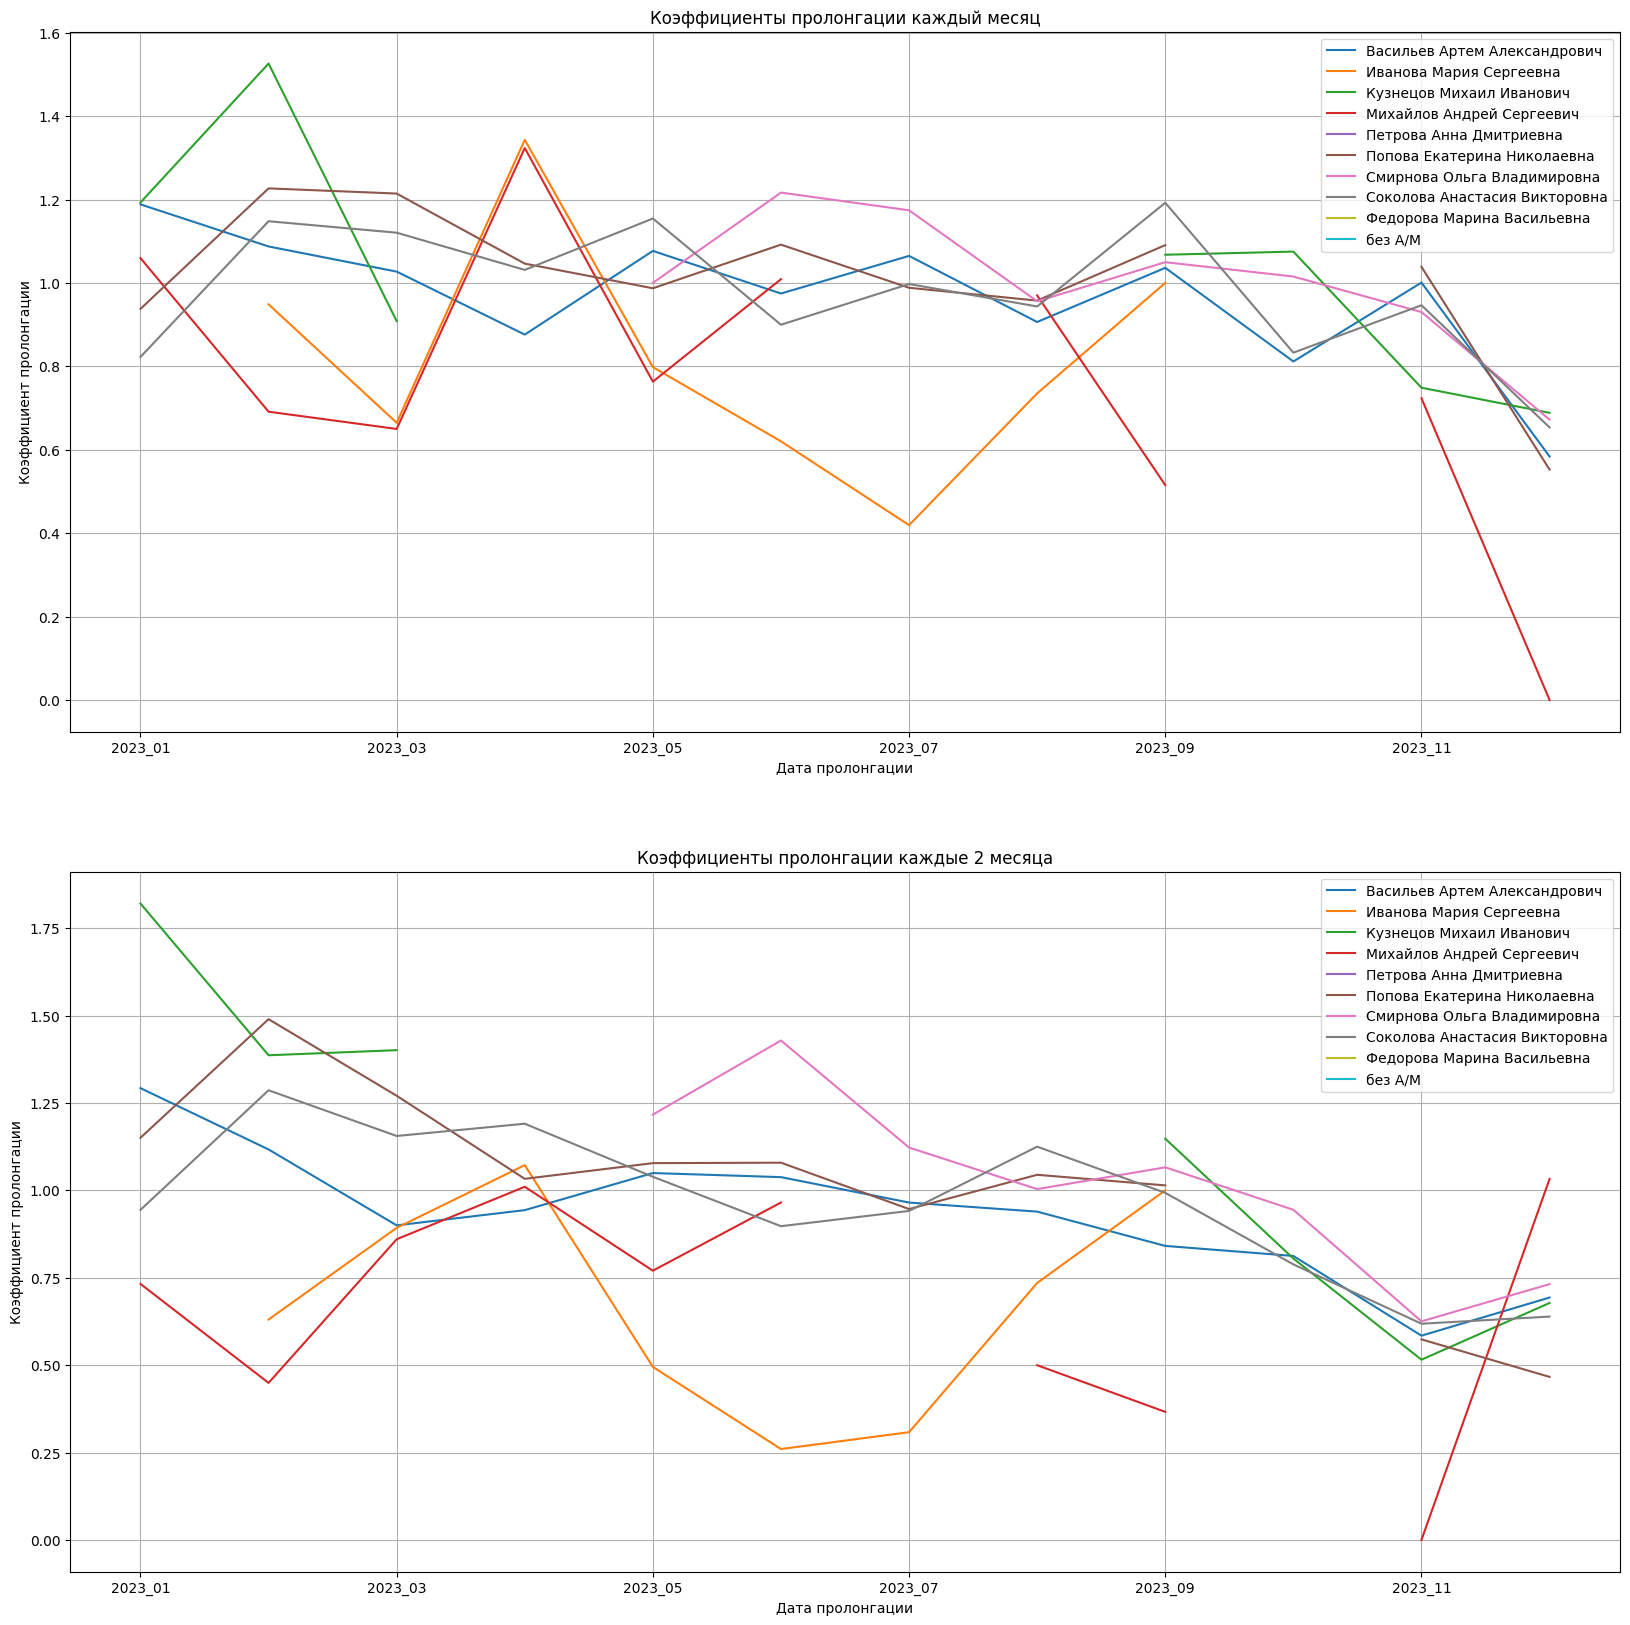

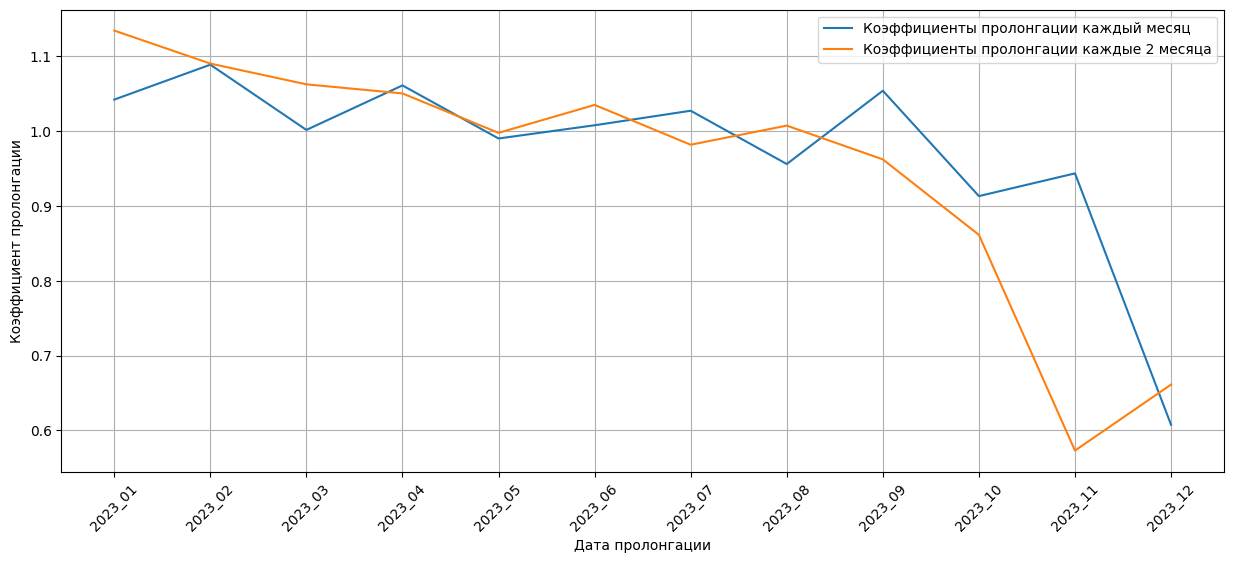

In [89]:
df_prolong, df_fin = clean_value(dataset_prolong, dataset_fin)
df_res1, df_res2 = get_coeff_per_month(df_fin, df_prolong)
df_res3, df_res4 = get_coeff_per_year(df_fin)
fig_each_month = plot_fig_each_month(df_res1, df_res2)
fig_per_year = plot_fig_per_year(df_res3, df_res4)
print(f'Коэффициенты пролонгации проектов в первый месяц: \n {df_res1}')
print(f'Коэффициенты пролонгации проектов во второй месяц: \n {df_res2}')
print(f'Коэффициенты пролонгации проектов в первый месяц за год: \n {df_res3}')
print(f'Коэффициенты пролонгации проектов во второй месяц за год: \n {df_res4}')

Судя по графикам коэффициента пролонгации, можно сделать несколько выводов:
1. На протяжении всего года менеджеры удерживались в пределах 1, только к концу года показатель "упал" до ~0.6. В частности менеджеры показывают стабильность показателей (Васильев, Попова, Смирнова, Соколова), в то время другие (Иванова, Михайлов) демонстрируют волнообразное изменение и нестабильность в работе с клиентами. У некоторых менеджеров была лишь 1 пролонгация, в связи с этим на графиках их коэффициент не отображен.
2. Общий тренд можно увидеть на третьем графике. В целом коэффициент пролонгации со значения 1.1 постепенно уменьшается до 0.85 и редко в октябре "падает" до ~0.6.
Получается к концу года показатель падает либо от уменьшения сумм отгрузок, либо уменьшения числа проектов, возможны, и другие факторы, влияющие на показатель (сезонность, изменения в спросе).
